In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.2)
sns.set_palette("tab10")
import statsmodels.formula.api as smf

%matplotlib widget

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Define the size of the dataset
n = 500

# Generate random data for the dataset
years_after_degree = np.random.randint(1, 31, size=n)  # years after degree (1 to 30 years)
degree = np.random.choice(['magic', 'juggling'], size=n)  # categorical: magic or juggling
country = np.random.choice(['Narnia', 'Oz', 'The Shire', 'Monstropolis'], size=n)  # categorical: 4 countries

# Simulate annual income based on degree, country, and years after degree
# These will introduce random effects for degree and country
income = (
    50 # Base intercept
    + np.where(degree == 'magic', 0,   # magic graduates earn 10 more
                                  10        # juggling graduates earn the base
              )  # Effect of degree major on intercept
    + np.where(country == 'Narnia', 0, # Narnia citizens earn the base
               np.where(country == 'Oz', -20, # Oz citizens earn 20 less
                        np.where(country == 'The Shire', 4, # The Shire citizens earn 4 more
                                                         16) # Monstropolis citizens earn 12 more
                        )
              )  # Effect of country on intercept
    + years_after_degree * 1.5  # Base slope
    + years_after_degree * (
          np.where(degree == 'magic', 0, # magic graduates earn 0.3 more per year
                                      0.3    # juggling graduates earn the base
                  )  # Effect of degree on intercept
          + np.where(country == 'Narnia', 0, # Narnia citizens earn 1 less per year 
                     np.where(country == 'Oz', -0.2, # Oz citizens earn 0.8 more per year
                              np.where(country == 'The Shire', 1.0, # The Shire citizens earn 0.4 more per year
                                                               -1) # Monstropolis citizens earn the base
                             )
                    )  # Effect of country on intercept

    )
    + np.random.normal(0, 5, size=n)  # Add noise
)

# Create a DataFrame
df = pd.DataFrame({
    'years_after_degree': years_after_degree,
    'degree': degree,
    'country': country,
    'income': income
})

df['id'] = np.arange(n)  # Add an ID column
# Save the DataFrame as a CSV file
output_path = 'mixed-model.csv'
df.to_csv(output_path, index=False)


<Axes: xlabel='years_after_degree', ylabel='income'>

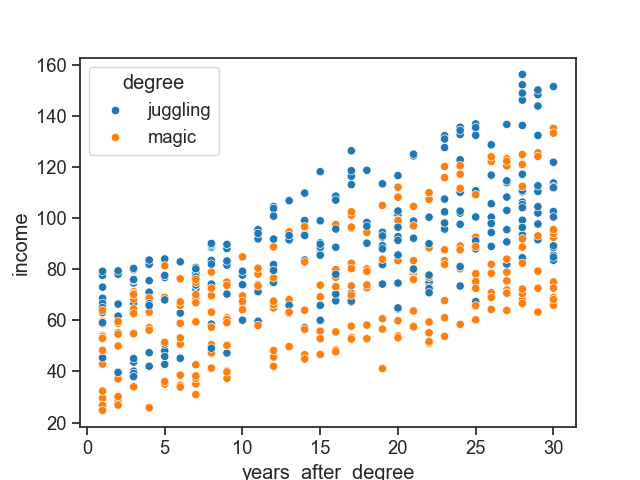

In [3]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='years_after_degree', y='income', hue='degree')
# ax.set(ylim=[-15,130])

<Axes: xlabel='years_after_degree', ylabel='income'>

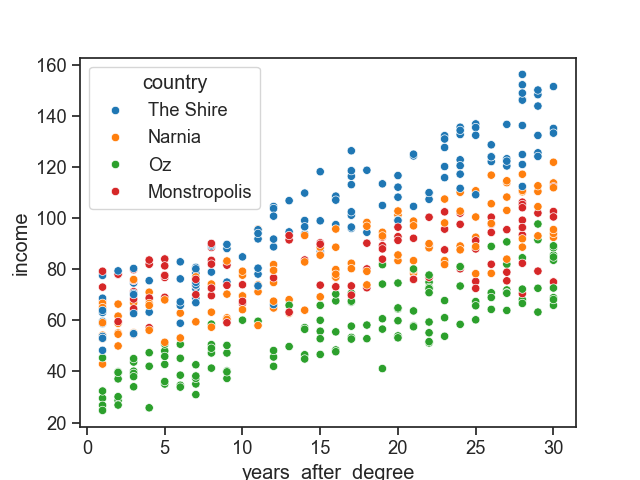

In [4]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='years_after_degree', y='income', hue='country')
# ax.set(ylim=[-15,130])

In [5]:
model = smf.mixedlm("income ~ years_after_degree * C(country) + years_after_degree * C(degree)",
                    df,
                    groups= "id").fit()

In [6]:
# Extracting results
params = model.params
bse = model.bse
tvalues = model.tvalues
pvalues = model.pvalues
conf_int = model.conf_int()
conf_int.columns = ['CI Lower', 'CI Upper']

# Creating the DataFrame
results_df = pd.DataFrame({
    'Parameter': params.index,
    'Coefficient': params.values,
    'Std. Error': bse.values,
    'z-value': tvalues.values,
    'p-value': pvalues.values,
    'CI Lower': conf_int['CI Lower'].values,
    'CI Upper': conf_int['CI Upper'].values
})

results_df

,Parameter,Coefficient,Std. Error,z-value,p-value,CI Lower,CI Upper
0,Intercept,75.639764,1.102333e+00,6.861790e+01,0.000000e+00,7.347923e+01,7.780030e+01
1,C(country)[T.Narnia],-15.889830,1.367161e+00,-1.162250e+01,3.167170e-31,-1.856942e+01,-1.321024e+01
2,C(country)[T.Oz],-36.812643,1.349320e+00,-2.728237e+01,6.866772e-164,-3.945726e+01,-3.416803e+01
3,C(country)[T.The Shire],-11.313934,1.382528e+00,-8.183512e+00,2.756899e-16,-1.402364e+01,-8.604229e+00
4,C(degree)[T.magic],-10.165981,9.406912e-01,-1.080693e+01,3.191848e-27,-1.200970e+01,-8.322260e+00
5,years_after_degree,0.852226,5.940123e-02,1.434695e+01,1.113273e-46,7.358022e-01,9.686508e-01
6,years_after_degree:C(country)[T.Narnia],0.970079,7.471845e-02,1.298312e+01,1.525303e-38,8.236334e-01,1.116524e+00
7,years_after_degree:C(country)[T.Oz],0.842475,7.426154e-02,1.134470e+01,7.879350e-30,6.969252e-01,9.880251e-01
8,years_after_degree:C(country)[T.The Shire],1.974674,7.529496e-02,2.622584e+01,1.348377e-151,1.827098e+00,2.122249e+00
9,years_after_degree:C(degree)[T.magic],-0.307839,5.151882e-02,-5.975273e+00,2.297057e-09,-4.088140e-01,-2.068640e-01


In [7]:
model = smf.mixedlm("""income ~ years_after_degree * C(country, Treatment(reference='Oz')) +
                                years_after_degree * C(degree, Treatment(reference='magic'))""",
                    df,
                    groups="id").fit()


/Users/yairmau/miniforge3/envs/olympus/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [8]:
# Extracting results
params = model.params
bse = model.bse
tvalues = model.tvalues
pvalues = model.pvalues
conf_int = model.conf_int()
conf_int.columns = ['CI Lower', 'CI Upper']

# Creating the DataFrame
results_df = pd.DataFrame({
    'Parameter': params.index,
    'Coefficient': params.values,
    'Std. Error': bse.values,
    'z-value': tvalues.values,
    'p-value': pvalues.values,
    'CI Lower': conf_int['CI Lower'].values,
    'CI Upper': conf_int['CI Upper'].values
})

results_df

,Parameter,Coefficient,Std. Error,z-value,p-value,CI Lower,CI Upper
0,Intercept,28.661140,0.728243,39.356576,0.000000e+00,27.233811,30.088470
1,"C(country, Treatment(reference='Oz'))[T.Monstr...",36.812643,1.131393,32.537454,3.150790e-232,34.595154,39.030132
2,"C(country, Treatment(reference='Oz'))[T.Narnia]",20.922814,0.736203,28.419887,1.148497e-177,19.479882,22.365745
3,"C(country, Treatment(reference='Oz'))[T.The Sh...",25.498709,0.949339,26.859442,6.543263e-159,23.638039,27.359379
4,"C(degree, Treatment(reference='magic'))[T.jugg...",10.165981,0.891292,11.405890,3.907609e-30,8.419080,11.912881
5,years_after_degree,1.386863,0.045677,30.362096,1.739663e-202,1.297336,1.476389
6,"years_after_degree:C(country, Treatment(refere...",-0.842475,0.064804,-13.000402,1.217019e-38,-0.969488,-0.715462
7,"years_after_degree:C(country, Treatment(refere...",0.127604,0.046838,2.724339,6.443037e-03,0.035802,0.219405
8,"years_after_degree:C(country, Treatment(refere...",1.132199,0.056615,19.998160,5.714199e-89,1.021235,1.243162
9,"years_after_degree:C(degree, Treatment(referen...",0.307839,0.047202,6.521792,6.947229e-11,0.215326,0.400352


In [9]:
print(results_df)

                                            Parameter  Coefficient  \
0                                           Intercept    28.661140   
1   C(country, Treatment(reference='Oz'))[T.Monstr...    36.812643   
2     C(country, Treatment(reference='Oz'))[T.Narnia]    20.922814   
3   C(country, Treatment(reference='Oz'))[T.The Sh...    25.498709   
4   C(degree, Treatment(reference='magic'))[T.jugg...    10.165981   
5                                  years_after_degree     1.386863   
6   years_after_degree:C(country, Treatment(refere...    -0.842475   
7   years_after_degree:C(country, Treatment(refere...     0.127604   
8   years_after_degree:C(country, Treatment(refere...     1.132199   
9   years_after_degree:C(degree, Treatment(referen...     0.307839   
10                                             id Var     1.000000   

    Std. Error    z-value        p-value   CI Lower   CI Upper  
0     0.728243  39.356576   0.000000e+00  27.233811  30.088470  
1     1.131393  32.537454  3.